## Classification

**Note: This is still a work in progress.**

In the [last lesson](https://github.com/VikParuchuri/zero_to_gpt/blob/master/explanations/dense.ipynb), we trained our neural network on a regression task. The network predicted a number, `tmax_tomorrow`, that can take on any value.  Regression in this case refers to the output of the model, not to linear regression (it's confusing, I know).

We can also train our model on a classification task.  In a classification task, we want the network to predict which category something belongs to.  In this lesson, we're going to predict if an object detected by a telescope is a star, a galaxy, or a quasar.

We could do this with regression, and have our output be `1`, `2`, or `3` to indicate a star, a galaxy, or a quasar.  There are issues with this, though:

- In the forward pass of a neural network, we multiply by the weights to get the output.  Let's say we predict a `1`, but we actually should have predicted a `2`.  We would need to increase the weights.  But a galaxy isn't twice as large as a star.  So the mapping doesn't make sense in the context of the input data.
- We can get an intermediate value like `1.5` as a prediction, which is hard to interpret.  We'd ideally want percentages indicating the chance that an example is each of the classes.
- The network can output values below `1` or above `3`.

Classification allows us to solve this problem - it lets us output the probability that an example belongs to each of the classes (star, galaxy, or quasar).  In classification, most of the neural network works the same - the two main things that change are the activation function and the loss function.

## Binary Classification

To start with, we'll train the network to perform binary classification.  In binary classification, our target is either a `0`, or a `1`.  A `1` means that there is a 100% chance of the item belonging to the category.

We're going to set up our target so that a star is a `1`, and other objects are `0`.  So our network will return something close to `1` if it thinks the telescope detected a star, and close to `0`, otherwise.

Let's load in our data:

In [94]:
import os
import sys

# Append the path so we can import the correct library
sys.path.append(os.path.abspath("../data"))
from csv_data import SkyServerBinaryDatasetWrapper

# Load in our data.  The wrapper handles the details of loading and processing the data for us.
wrapper = SkyServerBinaryDatasetWrapper("cpu")
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

In [95]:
train_x[:5]

array([[ 0.16745842, -0.58492272,  1.03148637, -0.34855938, -0.83728027,
        -0.94605772, -0.99534154, -0.83806089,  0.21085172, -0.21763043,
        -0.36973112,  1.03148936,  1.30931064],
       [ 0.16886159, -0.58311429,  0.05243046, -0.16653251, -0.15415531,
        -0.08264457, -0.02604308, -0.83806089,  0.21085172, -0.21763043,
        -0.36984929, -0.63621258, -0.87919741],
       [ 0.17057433, -0.58347525,  0.92156796,  0.86709322,  0.59315368,
         0.44120145,  0.31452753, -0.83806089,  0.21085172, -0.21147922,
        -0.05302706, -0.65633905, -0.60919097],
       [ 0.17455754, -0.58650069, -1.03063038, -0.81362749, -0.63669227,
        -0.52660429, -0.43092107, -0.83806089,  0.21085172, -0.20532801,
        -0.36999261,  1.03148936,  1.30931064],
       [ 0.17482457, -0.58441247, -1.29023238, -1.17251944, -0.37676237,
        -0.02510121,  0.15827647, -0.83806089,  0.21085172, -0.20532801,
        -0.36818949,  1.03148936,  1.30931064]])

As we can see above, we have 13 input variables to our network.  We'll use these 13 variables to predict a single target variable:

In [96]:
train_y[:5]

array([[0],
       [0],
       [1],
       [0],
       [0]])

As you can see above, the target is `0` when the object is not a star, and `1` otherwise.  We want our network to output a number between `0` and `1` indicating the probability that the object is a star.  This is called binary classification.  Let's learn how to set our network up to do this.

## Sigmoid activation

In the previous lesson, we didn't apply an activation function to the output of our network - we just output the last layer directly.  But in a binary classification problem, we want to predict either `0` or `1`.  A neural network can output values outside this range, so we need to constrain the outputs.

We can do this using the sigmoid function, which will ensure all outputs are inside the range `0` to `1`.  Mathematically, the sigmoid function is $\sigma=\frac{1}{1 + e^{-x}}$.  $e$ is a special number with a value around `2.71`, with the property that the natural log of $e$ equals `1`.  We use this exact formula because of how it interacts with the loss function (we'll see this later).

Raising the number $e$ to the power $-x$ will result in a number close to `0` when $x$ is high.  This is because a negative exponent is the product of fractions, like $3 ^ {-2}$ is equal to $1/3 * 1/3$.  When $x$ is large, the sigmoid will output a number very close to $1$, because $e^{-x}$ will be close to `0`, and the denominator will be close to `1`.

Raising the number $e$ to the power $-x$ when x is a negative number will make the value of $e^{-x}$ very large.  The negative sign in $e^{-x}$ will undo the negative sign on $x$, so we'll raise $e$ to a large positive power.  This will make the denominator very large, and push the sigmoid close to `0`.

You can see an example here:

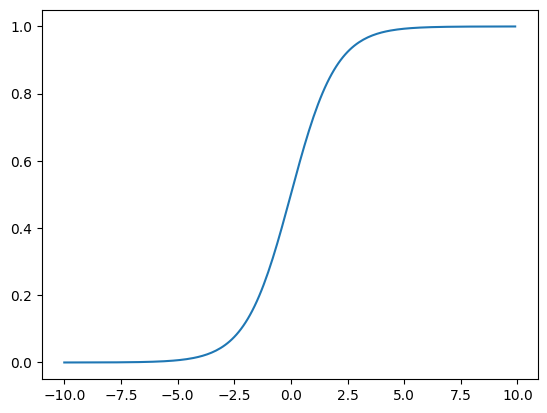

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Create an array of numbers from -10 to 10
nn_outputs = np.arange(-10,10,.1)
# Define the sigmoid function
sigmoid = lambda x: 1 / (1 + np.exp(-x))

plt.plot(nn_outputs, sigmoid(nn_outputs))

Our network will output continuous real numbers in the last layer, and the sigmoid function will transform them into probabilities from `0` to `1`.  The sigmoid will output the probability that the example belongs to a given class.  For example, if we code a star as `1`, and everything else as a `0`, the output of the sigmoid activation tells us the probability that an example is a star.  The sigmoid output might be `.51`, corresponding to a 51% probability.

## Negative Log Likelihood

Because the range of values after we apply the sigmoid function is so small, mean squared error isn't the best loss function.  If the actual target is a `1`, and we predict a `.5`, mean squared error will only be `.25`.  Here is how mean squared error looks with binary classification:

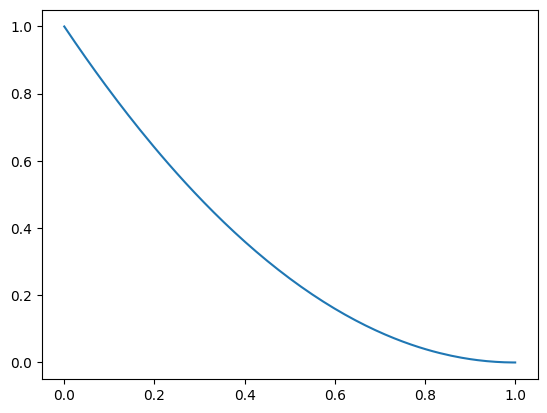

In [98]:
mse = lambda pred, actual: (actual - pred) ** 2
output_probs = sigmoid(nn_outputs)

plt.plot(output_probs, mse(output_probs, 1))

As you can see, mean squared error only ranges between `0` and `1`.  This can make it hard for the network to penalize incorrect guesses and adjust the weights properly.  We instead want a function that will penalize incorrect predictions much more than predictions that are close to the actual value.

We can instead use the negative log likelihood, which is defined as $NLL = -(y * log(\hat{y}) + (1-y) * log(1-\hat{y}))$.  Since $y$ is always `0` or `1`, one half of the equation will always be `0`.  Let's say $y$ is `1`, and $\hat{y}$ is `.7`.

$$NLL = -(1 * log(.7) + (1-1) * (1-.7))$$
$$NLL = -(1 * log(.7) + 0 * (1-.7))$$
$$NLL = -(1 * log(.7))$$
$$NLL = -(1 * log(.7))$$
$$NLL = .3566$$

Remember that $log .7$ means "to what power do I need to raise $e$ to get `.7`?"  To get a number between `0` and  `1` (which is what the sigmoid function outputs), you have to raise $e$ to a negative power.  Raising to a negative power is the same as repeatedly multiplying $1/e$ by itself.  The closer $\hat{y}$ is to `1`, the lower the negative power (the further from `0`).

You then "undo" the negative with the beginning negative sign for negative log likelihood.  Note that $log 0$ is undefined, so we have to be careful not to pass `0` in as our prediction.  Luckily, the sigmoid function cannot output `0`, since the sigmoid is $1/(1+e^{-x}$.  As $e^{-x}$ increases, the sigmoid outputs numbers closer and closer to `0`, but never reaches `0`.

Let's see how negative log likelihood changes as we change our predictions.  We're assuming that the correct target is `1`:

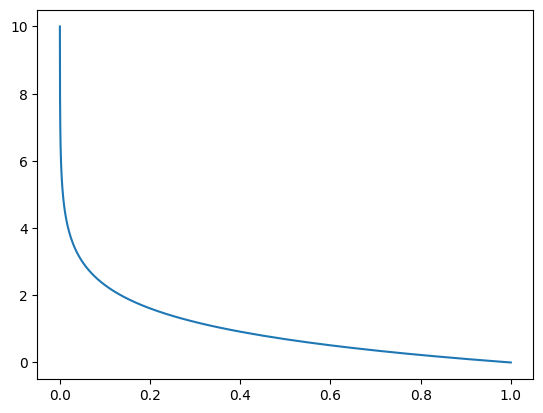

In [99]:
# Define negative log likelihood function
nll = lambda pred, actual: -(actual * np.log(pred) + (1-actual) * np.log((1-pred)))

# Plot negative log likelihood against our simulated output probabilities
plt.plot(output_probs, nll(output_probs, 1))

We can see that negative log likelihood gets very large as our prediction gets closer to `0`.  This loss function will penalize big errors in predictions more than mean squared error.

## Training Loop - Binary Classification

We now know enough to try binary classification using our neural network.  We'll run the network normally, but apply the sigmoid function to the output layer, then measure error with negative log likelihood.

In the last lesson, we trained a neural network to make predictions.  We'll use the same code as last time, but this time we'll define our neural network using a class.  This helps us avoid rewriting all of the same code from last time again.

We'll define a neural network with 2 layers.  Layer 1 will take in 13 input features, and convert them into 25 features.  Layer 2 will take those 25 features, and turn them into a single output.

In [100]:
# Append to the path, so we can import our neural network
sys.path.append(os.path.abspath("../nnets"))
from dense import Dense

class ClassificationNet():
    def __init__(self, output_size=1):
        # Setup 2 neural network layers.  Each Dense class is a single network layer.
        # We don't use relu activation on the second layer, but we do in the first layer.
        self.layer1 = Dense(input_size=13, output_size=25)
        self.layer2 = Dense(input_size=25, output_size=output_size, activation=False)
        self.last_input = None
        super().__init__()

    def forward(self, x):
        # In the forward pass, we take in input data, and run our 2 layers over the data.
        x = self.layer1.forward(x)
        x = self.layer2.forward(x)
        return x

    def backward(self, grad, lr):
        # In the backward pass, we take the gradient and learning rate, and use them to adjust parameters in each layer.
        grad = self.layer2.backward(grad, lr)
        grad = self.layer1.backward(grad, lr)

The forward and backward pass will mostly work the same way they did in the last lesson.  The main difference is in how we calculate the gradient of the loss function and backpropagate it across the sigmoid activation.

As mentioned earlier, our network will output a single number in the last layer - let's call this $z$.  We'll then run the sigmoid function over $z$ to get the output probability $p$.  We'll then use a loss function $L$ (negative log likelihood) to calculate how far we were from the actual target.

The derivative of the loss function $L$ with respect to the predicted probabilities $p$ is $\frac{\partial L}{\partial p}=\frac{p-y}{p(1-p)}$.  And the derivative across the sigmoid function of the probabilities $p$ with respect to the neural network output $z$ is $\frac{\partial p}{\partial z}=p(1-p)$.  If we want to compute the partial derivative of the loss $L$ with respect to the neural network output $z$, we multiply the two by the chain rule:

$$\frac{\partial L}{\partial z} = \frac{\partial L}{\partial p} * \frac{\partial p}{\partial z}$$
$$\frac{\partial L}{\partial z} = \frac{p-y}{p(1-p)} * \frac{\partial p}{\partial z}=p(1-p)$$
$$\frac{\partial L}{\partial z} = p - y$$

Luckily for us, the denominator multiplies out, and we're left with $p-y$, or the predicted probabilities minus the target.  So in one step, we'll calculate the gradient with respect to the output of our neural network:

In [101]:
# Computes the gradient with respect to the outputs of the neural network
# Input will be the sigmoid function applied to the neural network outputs
nll_grad = lambda pred, actual: pred - actual

We can see that this gives us a clear gradient that we can follow with gradient descent:

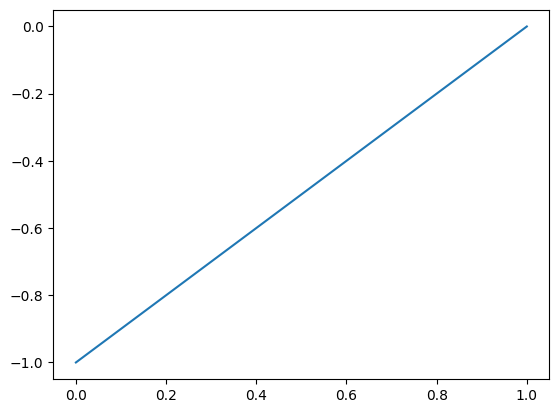

In [102]:
plt.plot(output_probs, nll_grad(output_probs, 1))

We can now write the training loop using sigmoid activation and negative log likelihood:

In [103]:
net = ClassificationNet()
lr = 1e-2
epochs = 50

for epoch in range(epochs):
    epoch_loss = 0
    for x, target in zip(train_x, train_y):
        x = x.reshape(1,-1)
        # Run the sigmoud function over the output of the neural network
        pred = sigmoid(net.forward(x))

        # Compute the gradient using the nll_grad function
        grad = nll_grad(pred, target)
        epoch_loss += nll(pred, target)[0,0]

        # Update the network parameters
        net.backward(grad, lr)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} train loss: {epoch_loss / len(train_x)}")
        epoch_loss = 0
        for x, target in zip(valid_x, valid_y):
            x = x.reshape(1,-1)
            pred = sigmoid(net.forward(x))
            epoch_loss += nll(pred, target)[0,0]
        print(f"Valid loss: {epoch_loss / len(valid_x)}")

Epoch 0 train loss: 0.2682927454493638
Valid loss: 0.26448187252356126
Epoch 10 train loss: 0.10106777344637874
Valid loss: 0.12040902930724136
Epoch 20 train loss: 0.076515962768458
Valid loss: 0.09385188397071516
Epoch 30 train loss: 0.06805932971500155
Valid loss: 0.09548004093000301
Epoch 40 train loss: 0.0624920649725441
Valid loss: 0.10128727568213479


As we can see above, we were able to reduce the loss from epoch to epoch and fit the data fairly well by the end of training.

## Classification With Multiple Targets

Now that we've covered binary classification, let's cover classification with multiple targets.  Let's say that our telescope can id `3` different kinds of objects, and we want to know the probability that it has detected each one.  These 3 objects are stars, galaxies, and quasars.

We can't use binary classification, since that can only tell us if a single object is present or not.  We'll instead need to use multi-class classification.

Our first step is to encode our targets into one-hot vectors.  Each position in the vector will correspond to a single class.  We'll say that a star corresponds to position `0`, a galaxy to position `1`, and a quasar to position `2`:

In [104]:
def encode(target, max_value=3):
    encoded = np.zeros((1,max_value))
    encoded[0,target] = 1
    return encoded

In [105]:
# Encode a star
print(encode(0))

# Encode a galaxy
print(encode(1))

# Encode a quasar
print(encode(2))

[[1. 0. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


As you can see above, we end up with a 3-element vector after encoding.  The position in the vector that is `1` corresponds to our class label (star, galaxy, or quasar).  This is why it is called one-hot encoding - only one position in the vector is non-zero.

We'll use our network to predict this vector by outputting 3 number.  Similar to what we did with the sigmoid function, we need a way for the network to output values between `0` and `1` for each position in the vector.

We also need all of the elements in the output vector to add to `1`.  Each vector element is the probability that the item belongs to that class.  Our total probability has to be `100%`.

## Softmax Function

The softmax function will normalize the values in our output vector to meet the criteria above:

$\zeta=\frac{e^{\hat{y_{i}}}}{\sum_{i=j}e^{\hat{y_{j}}}}$

Confusingly, the softmax and sigmoid functions usually the same symbol to define them.  To eliminate that confusion, we'll use $\zeta$ for softmax.  Intuitively, the softmax will raise the current prediction to the power $e^{y_{i}}$, then divide by the sum of all the other predictions.  Larger predictions will get pushed closer to `1`, and smaller predictions will get pushed closer to `0`.  This is why it is called a softmax - it is a "softer" way of taking the maximum of the vector.

Let's take a look at the function:

In [106]:
def softmax(preds):
    # Raise e to the power of each of the predictions
    preds = np.exp(preds)
    # Divide the predictions by the sum
    return preds / np.sum(preds)

In [107]:
softmax(np.array([10,20,30]))

array([2.06106005e-09, 4.53978686e-05, 9.99954600e-01])

As you can see above, softmax pushed `30` very close to `1` in the output vector, and pushed the other 2 values close to `0`.

## Log Loss

We use log loss as our loss metric.

In [108]:
def log_loss(predicted, actual):
    tol = 1e-6
    cross_entropy = actual * np.log(predicted + tol)
    return -np.sum(cross_entropy)

## Log loss gradient

Luckily, the gradient of log loss and the softmax end up with the same gradient as sigmoid and negative log likelihood.

In [109]:
log_loss_grad = lambda pred, actual: pred - actual

## Training Loop - Multiple Classes

In [110]:
from csv_data import SkyServerDatasetWrapper


wrapper = SkyServerDatasetWrapper("cpu")
[train_x, train_y], [valid_x, valid_y], [test_x, test_y] = wrapper.get_flat_datasets()

In [112]:
net = ClassificationNet(3)
lr = 1e-3
epochs = 50

for epoch in range(epochs):
    epoch_loss = 0
    for x, target in zip(train_x, train_y):
        x = x.reshape(1,-1)
        # Run the softmax function over the output of the neural network
        pred = softmax(net.forward(x))

        target = encode(target)
        # Compute the gradient using the nll_grad function
        grad = log_loss_grad(pred, target)
        epoch_loss += log_loss(pred, target)

        # Update the network parameters
        net.backward(grad, lr)

    if epoch % 10 == 0:
        print(f"Epoch {epoch} train loss: {epoch_loss / len(train_x)}")
        epoch_loss = 0
        for x, target in zip(valid_x, valid_y):
            x = x.reshape(1,-1)
            pred = softmax(net.forward(x))
            target = encode(target)
            epoch_loss += log_loss(pred, target)
        print(f"Valid loss: {epoch_loss / len(valid_x)}")

Epoch 0 train loss: 0.5340438424762264
Valid loss: 0.369248679718005
Epoch 10 train loss: 0.17076418611771466
Valid loss: 0.2060768028825078
Epoch 20 train loss: 0.12944873470801835
Valid loss: 0.16616614005982078
Epoch 30 train loss: 0.10977823237985218
Valid loss: 0.14806029236884094
Epoch 40 train loss: 0.09653654780216854
Valid loss: 0.13613702515812218
